In [11]:
# 生成训练数据

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


np.random.seed(4040)
## 设定数据个数
n = 4000
features = ["x1", "x2", "x3", "x4"]
label = "y"
X, y = make_classification(n_samples=n, n_features=4)
data = pd.DataFrame(X, columns=features)
data[label] = y
data.head()

,x1,x2,x3,x4,y
0,2.944204,1.259939,-1.321866,2.514267,1
1,-2.398223,-1.181556,1.049449,-1.982192,0
2,-1.533353,0.119723,0.824793,-1.638382,0
3,-0.221797,1.415816,0.365082,-0.829876,0
4,-1.252638,-0.522779,0.564732,-1.075345,0


In [14]:
# 划分训练集和测试集

from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(data, test_size=0.5)
## res用来记录模型结果
res = {}

In [15]:
# 单独使用逻辑回归

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve


logit_model = LogisticRegression()
logit_model.fit(train_data[features], train_data[label])
logit_prob = logit_model.predict_proba(test_data[features])[:, 1]
res["logit"] = roc_curve(test_data[label], logit_prob)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
# 单独使用决策树

from sklearn.tree import DecisionTreeClassifier

    
dt_model = DecisionTreeClassifier(max_depth=2, criterion="gini")
dt_model.fit(train_data[features], train_data[label])
dt_prob = dt_model.predict_proba(test_data[features])[:, 1]
res["DT"] = roc_curve(test_data[label], dt_prob)

In [22]:
# 决策树和逻辑回归联结

from sklearn.preprocessing import OneHotEncoder


## 为了防止过拟合，使用不同的数据训练决策树和逻辑回归
train_DT, train_LR = train_test_split(train_data, test_size=0.5)
## 使用决策树对前两个变量做变换
m = 2
_dt = DecisionTreeClassifier(max_depth=2)
_dt.fit(train_DT[features[:m]], train_DT[label])
## 得到数据所在的叶子节点
leaf_node = _dt.apply(train_DT[features[:m]]).reshape(-1, 1)
print(leaf_node[:10])

[[2]
 [6]
 [6]
 [5]
 [6]
 [5]
 [5]
 [3]
 [5]
 [3]]


In [23]:
# 决策树和逻辑回归联结
## 生成虚拟变量
coder = OneHotEncoder()
coder.fit(leaf_node)
new_feature = np.c_[
    coder.transform(_dt.apply(train_LR[features[:m]]).reshape(-1, 1)).toarray(),
    train_LR[features[m:]]]
print(new_feature[:10])
_logit = LogisticRegression()
_logit.fit(new_feature[:, 1:], train_LR[label])
## 对测试集的数据做同样的处理
test_feature = np.c_[
    coder.transform(_dt.apply(test_data[features[:m]]).reshape(-1, 1)).toarray(),
    test_data[features[m:]]]
dt_logit_prob = _logit.predict_proba(test_feature[:, 1:])[:, 1]
res["DT + logit"] = roc_curve(test_data[label], dt_logit_prob)

[[ 0.          0.          1.          0.         -1.23602969  2.64616449]
 [ 1.          0.          0.          0.          0.94457739 -1.89761844]
 [ 0.          0.          1.          0.         -0.72270499  1.34885999]
 [ 0.          1.          0.          0.          0.66035215 -1.34959337]
 [ 0.          0.          1.          0.          0.11979902 -0.25707934]
 [ 0.          0.          1.          0.         -1.13728065  2.43843765]
 [ 0.          0.          1.          0.         -0.73468594  1.37109677]
 [ 0.          0.          0.          1.         -0.31137046  0.42407444]
 [ 0.          0.          1.          0.         -1.0811534   2.31820013]
 [ 0.          0.          0.          1.         -0.32952764  0.45556435]]


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


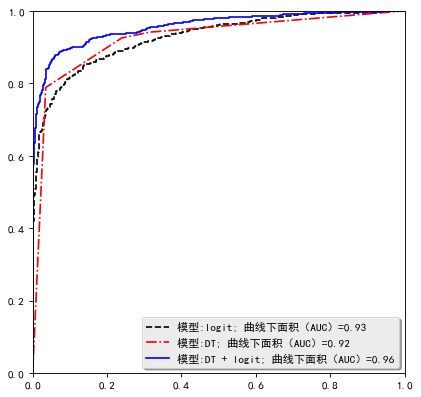

In [25]:
# 将模型结果可视化

import matplotlib.pyplot as plt
from sklearn.metrics import auc


## 创建一个图形框
fig = plt.figure(figsize=(6, 6), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
styles = ["k--", "r-.", "b"]
model = ["logit", "DT", "DT + logit"]
for i, s in zip(model, styles):
    fpr, tpr, _ = res[i]
    _auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, s,
            label="%s:%s; %s=%0.2f" % ("模型", i, "曲线下面积（AUC）", _auc))
legend = plt.legend(loc=4, shadow=True)
plt.show()